In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


# Optical flow


### Overview
    
    This python notebook contains code that computes the following
    
    - Computes optical flow
    - Tracks bounding box and good features
    - Outputs from the result
    
### Steps to compute optical flow

    - Compute image derivatives dx, dy and dt
        - dx - convolution with
$$
\begin{bmatrix}
-1 & 0 & 1
\end{bmatrix}
$$

        - dy - convolution with
$$
\begin{bmatrix}
-1 \\
0 \\
1
\end{bmatrix}
$$
        - dt - image[t] - image[t-1]
        
    - For each pixel calculate optical flow across the filter size using the following equations
$$
A = \begin{bmatrix}
\sum dx^2 & \sum dx*dy \\
\sum dx*dy & \sum dy^2 \\
\end{bmatrix}
$$

$$
b = \begin{bmatrix}
- \sum dx*dt \\
- \sum dy*dt \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
u \\
v \\
\end{bmatrix} = A^{-1}*b
$$

In [2]:
'''
Author: Rahul Sajnani

'''
def compute_image_derivative(image):
    
    '''
    Function to compute image derivative along x and y axis
    
    Input:
        image - H x W - input image
    Returns:
        list of image derivatives along x and y axis 
    '''
    
    image_x_filter = np.array([[ -1, 0, 1]])

    image_y_filter = np.array([[ -1],
                               [  0],
                               [  1]])

    image_x_derivative = cv2.filter2D(image, -1, image_x_filter)
    image_y_derivative = cv2.filter2D(image, -1, image_y_filter)
    
    return [image_x_derivative, image_y_derivative]
    
def compute_optical_flow(image_1, image_2, filter_size):
    
    '''
    Computes optical flow between two images
    
    Input:
        image_1 - H x W - input image 1
        image_2 - H x W - input image 2
        filter_size - tuple - filter size
        
    Returns:
        flow_matrix - H x W x 2 - matrix with flow vectors
        
    '''
    
    if (len(image_1.shape) > 1) and (len(image_2.shape) > 1):
        image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
        image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    
    image_1 = normalize_image(image_1)
    image_2 = normalize_image(image_2)
    
    image_1_derivative = compute_image_derivative(image_1)
    image_2_derivative = compute_image_derivative(image_2)
    
    # dx^2
    image_x_derivative_square = image_1_derivative[0] * image_1_derivative[0]
    
    # dy^2
    image_y_derivative_square = image_1_derivative[1] * image_1_derivative[1]
    
    # dx*dy
    image_xy_derivative = image_1_derivative[0] * image_1_derivative[1]
    
    # dt 
    image_t_derivative = image_2 - image_1
    
    image_xt_derivative = image_1_derivative[0] * image_t_derivative
    image_yt_derivative = image_1_derivative[1] * image_t_derivative
    
    summation_filter = np.ones(filter_size) 
    
    
    # computing summation dx^2, dy^2, dx*dt, dy*dt, dx*dy
    image_xt_derivative_summation = cv2.filter2D(image_xt_derivative, -1, summation_filter)
    image_yt_derivative_summation = cv2.filter2D(image_yt_derivative, -1, summation_filter)
    image_x_derivative_square_summation = cv2.filter2D(image_x_derivative_square, -1, summation_filter)
    image_y_derivative_square_summation = cv2.filter2D(image_y_derivative_square, -1, summation_filter)
    image_xy_derivative_summation = cv2.filter2D(image_xy_derivative, -1, summation_filter)
    
    flow_matrix = np.zeros((image_1.shape[0], image_1.shape[1], 2))
    
    for i in range(image_1.shape[0]):
        
        for j in range(image_1.shape[1]):
            
            # computing matrix
            optical_flow_mat = np.array([[image_x_derivative_square_summation[i, j], image_xy_derivative_summation[i, j]], 
                                        [image_xy_derivative_summation[i, j], image_y_derivative_square_summation[i, j]]])
            # print(optical_flow_mat.shape)
            b = -np.array([[image_xt_derivative_summation[i, j]], [image_yt_derivative_summation[i, j]]])
            
            flow_vector = np.linalg.pinv(optical_flow_mat) @ b
            
            factor = np.sqrt(flow_vector[0]**2 + flow_vector[1]**2)
            if factor > 0.3:
                flow_matrix[i, j, :] = flow_vector.T 
                
            # print(flow_vector)
        # print(i)
    
    
    print('Optical flow computed')
    print(np.max(flow_matrix))
    return flow_matrix

def plot_flow_image(image, flow_matrix):
    '''
    Plot flow vectors on image
    
    '''
    plt.imshow(image, 'gray')
    for i in range(0, flow_matrix.shape[0], 30):
        for j in range(0, flow_matrix.shape[1], 30):
            plt.quiver(j, i, flow_matrix[i, j, 0], flow_matrix[i, j, 1], scale = 10)
            
def normalize_image(image):
    '''
    Function to normalize image
    '''
    image = (image - np.mean(image)) /255
    
    return image

def get_good_features(image_1):
    '''
    Extract good features from image
    '''
    
    if len(image_1.shape) > 1:
        image_1_gray = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    else:
        image_1_gray = image_1
        
    corners = cv2.goodFeaturesToTrack(image_1_gray, 200, 0.01, 10)
    corners = np.int0(corners)
    corners = np.reshape(corners, (-1, 2))
    
    return corners

def segmentation(image, flow_matrix):
    '''
    Get segmentation of moving objects using flow matrix
    '''
    segmentation_mask = np.zeros((image.shape[0], image.shape[1]))
    
    for i in range(image.shape[0]):
        
        for j in range(image.shape[1]):
            
            segmentation_mask[i, j] = np.sqrt(flow_matrix[i, j, 0]**2 + flow_matrix[i, j, 1]**2)
    
    plt.imshow(segmentation_mask, 'gray')
    plt.show()

def SaveImages(directoryName, list_images):
    '''
    function to convert video to images
    Input:
        directoryName - name of direcotry to output images 
        list_images - list - list of images
    Output:
        none
    '''
    if not os.path.exists(directoryName):
        os.makedirs(directoryName)

    
    print('saving images')
    for i in range (len(list_images)):
        imageName = '%06d.jpg' % i
        imagePath = directoryName + '/' + imageName
        cv2.imwrite(imagePath, list_images[i])
    print('Save complete. Output saved in ' + directoryName)

def Image2Vid(dirName, fps, outputDir, vidName):

    '''
    function to conver images to video with given fps
    Input:
        dirName - directory name with images
        fps - output fps
        outputDir - output directory name to save video
    Output:
        none
    '''
    
    
    imageArray = []
    files = [images for images in os.listdir(dirName) if os.path.isfile(os.path.join(dirName, images))]
    files.sort()
    
    if not os.path.exists(outputDir):
        os.makedirs(outputDir)

    for i in range(len(files)):
        fileName = dirName + '/'+ files[i]
        image = cv2.imread(fileName)
        imageArray.append(image)
    
    height, width, layers = imageArray[0].shape
    size = (width, height)

    video = cv2.VideoWriter(outputDir + '/' + vidName,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(imageArray)):
        video.write(imageArray[i])
    video.release()
    print('Video path ' + outputDir + '/' + vidName)
    
    
def bounding_box_tracking(directory, bbox = None):
    '''
    Function to move bounding box by the optical flow obtained from the good features within the box
    '''
    
    imageArray = []
    image_array_output = []
    
    files = [images for images in os.listdir(directory)]
    files.sort()
    
    for i in range(len(files)):
        print(i)
        fileName = directory + '/'+ files[i]
        image = cv2.imread(fileName)
        imageArray.append(image)
    
    
    
    if bbox is None:
        print('Draw bounding box')
        r = cv2.selectROI(imageArray[0]) 
        bbox = [r[0], r[1], r[0] + r[2], r[1] + r[3]]
        bbox = bbox
    
    cv2.destroyAllWindows()
    mult_factor = 3
    running_bbox = bbox
    filter_size = ( 31, 31)
    for i in range(len(imageArray) - 1):
        
        bounding_box_shift_x = 0
        bounding_box_shift_y = 0
        # compute flow
        flow_matrix = compute_optical_flow(imageArray[i], imageArray[i + 1], filter_size)
        corners = get_good_features(imageArray[i])
        
        corners_in_box = np.logical_and(np.logical_and(corners[:, 0] > running_bbox[0], 
                                                       corners[:, 0] < running_bbox[2]), 
                                        np.logical_and(corners[:, 1] > running_bbox[1],
                                                       corners[:, 1] < running_bbox[3]))
        
        corners_in_box = corners[corners_in_box, :]
        
        if corners_in_box.shape[0] > 0:
            
            total_points = corners_in_box.shape[0]
            
            for points in corners_in_box:
                bounding_box_shift_x += mult_factor*flow_matrix[points[1], points[0], 0] / total_points
                bounding_box_shift_y += mult_factor*flow_matrix[points[1], points[0], 1] / total_points
        
        print(running_bbox)
        running_bbox = [int(running_bbox[0] + bounding_box_shift_x), 
                        int(running_bbox[1] + bounding_box_shift_y),
                        int(running_bbox[2] + bounding_box_shift_x),
                        int(running_bbox[3] + bounding_box_shift_y)]
        
        print(running_bbox)
        
        next_image = imageArray[i + 1]
        cv2.rectangle(next_image, (int(running_bbox[0]), int(running_bbox[1])),
          (int(running_bbox[2]), int(running_bbox[3])), (0, 255, 0), 2)
        plt.imshow(next_image)
        plt.show()
        image_array_output.append(next_image)
    
    folder = directory.split('/')[-1]
    directory_output = './outputs/' + folder
    SaveImages(directory_output, image_array_output)
    Image2Vid(directory_output, 8, directory_output + '/output', 'video.mp4')
    
    

Optical flow computed
1.8176778334267094


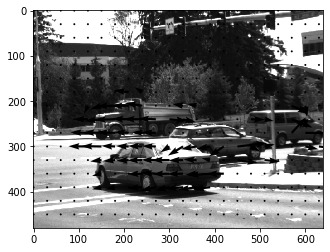

In [3]:
if __name__ == '__main__':
    
    dataset = './eval-data-gray'
    
    directory = '/Dumptruck'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)
    
    

Optical flow computed
5.765109935609735


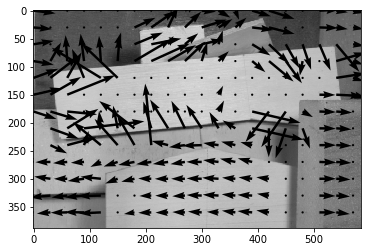

In [4]:
    directory = '/Wooden'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)
    

Optical flow computed
1.3436528180770413


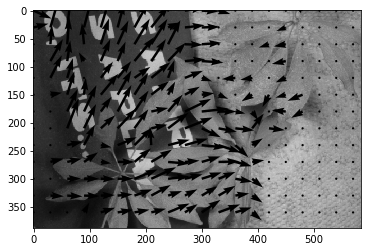

In [5]:
    directory = '/Schefflera'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)

Optical flow computed
0.8440589903756118


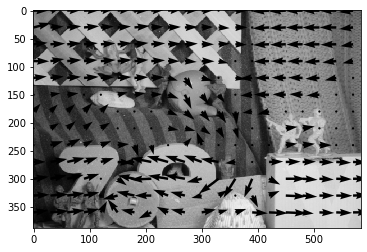

In [6]:
    directory = '/Army'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)

Optical flow computed
1.5299213790854143


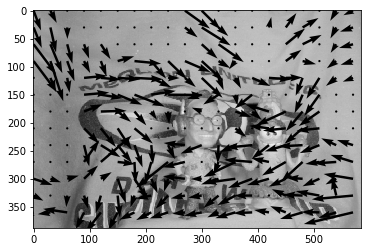

In [7]:
    directory = '/Mequon'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)

Optical flow computed
2.2360458885028005


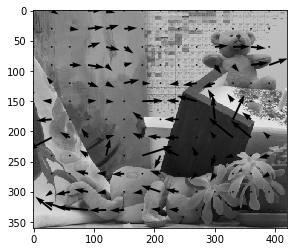

In [8]:
    directory = '/Teddy'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)

Optical flow computed
2.6626510680615745


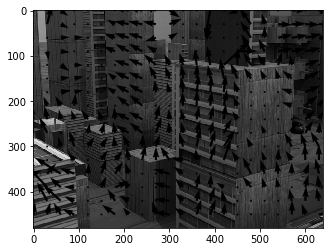

In [9]:
    directory = '/Urban'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)

0
1
2
3
4
5
6
7
Draw bounding box
Optical flow computed
2.8738112414310057
[138, 288, 420, 410]
[136, 287, 418, 409]


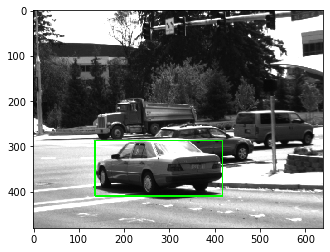

Optical flow computed
2.2952603664055116
[136, 287, 418, 409]
[135, 286, 417, 408]


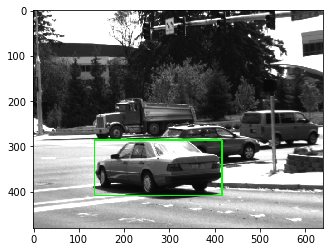

Optical flow computed
1.994550463940301
[135, 286, 417, 408]
[134, 285, 416, 407]


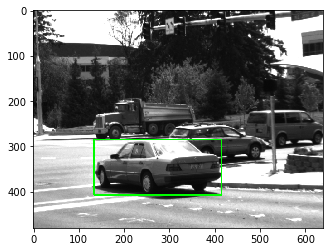

Optical flow computed
2.3441372601900685
[134, 285, 416, 407]
[133, 284, 415, 406]


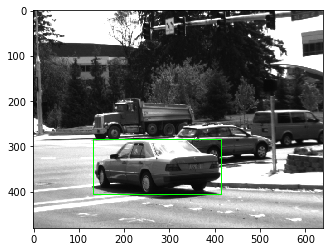

Optical flow computed
2.0437202319965615
[133, 284, 415, 406]
[132, 284, 414, 406]


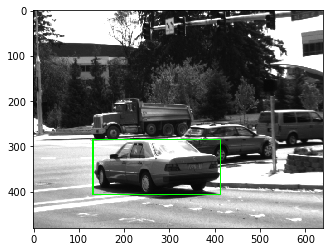

Optical flow computed
4.30436298564635
[132, 284, 414, 406]
[131, 283, 413, 405]


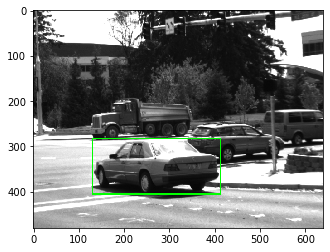

Optical flow computed
2.650815060523958
[131, 283, 413, 405]
[130, 282, 412, 404]


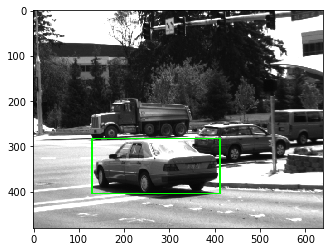

saving images
Save complete. Output saved in ./outputs/Dumptruck
Video path ./outputs/Dumptruck/output/video.mp4


In [10]:
    dataset_complete = './eval-data-gray-complete'
    directory = '/Dumptruck'
    bbox = [119, 275, 460, 414]
    bounding_box_tracking(dataset_complete + directory)

#### Case when moving camera
    During camera motion the optical flow does not perform very well for large motion

0
1
2
3
4
5
6
7
Optical flow computed
7.041625519088246
[208, 284, 338, 461]
[207, 285, 337, 462]


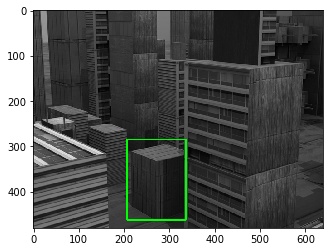

Optical flow computed
5.182976615561201
[207, 285, 337, 462]
[207, 284, 337, 461]


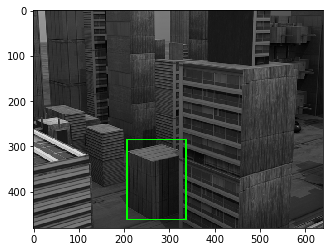

Optical flow computed
5.609495922825985
[207, 284, 337, 461]
[207, 284, 337, 461]


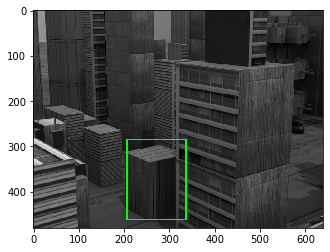

Optical flow computed
3.6354003023569557
[207, 284, 337, 461]
[206, 284, 336, 461]


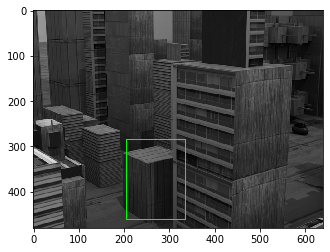

Optical flow computed
4.771851684058273
[206, 284, 336, 461]
[205, 284, 335, 461]


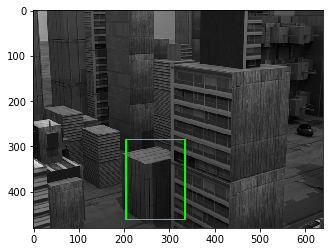

Optical flow computed
7.198882837905978
[205, 284, 335, 461]
[204, 284, 334, 461]


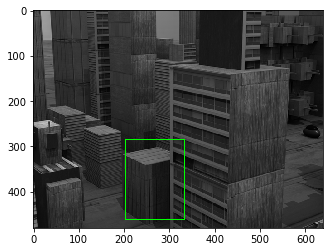

Optical flow computed
9.718489130091623
[204, 284, 334, 461]
[204, 284, 334, 461]


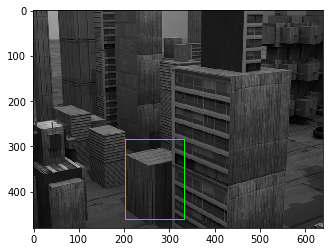

saving images
Save complete. Output saved in ./outputs/Urban
Video path ./outputs/Urban/output/video.mp4


In [11]:
    dataset_complete = './eval-data-gray-complete'
    directory = '/Urban'
    bbox = [208, 284, 338, 461]
    bounding_box_tracking(dataset_complete + directory, bbox)

0
1
2
3
4
5
6
7
Draw bounding box
Optical flow computed
8.858538359497805
[131, 245, 469, 387]
[129, 245, 467, 387]


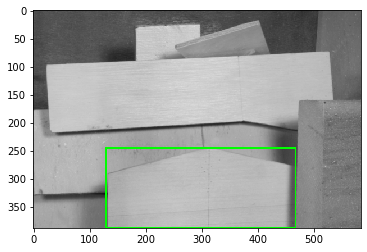

Optical flow computed
10.651547220163856
[129, 245, 467, 387]
[128, 245, 466, 387]


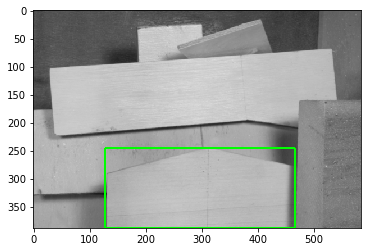

Optical flow computed
9.651471870572792
[128, 245, 466, 387]
[127, 245, 465, 387]


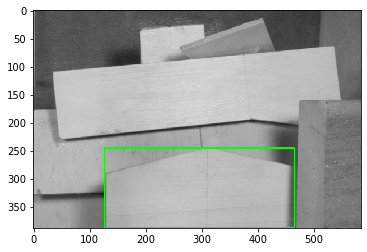

Optical flow computed
7.935027316423763
[127, 245, 465, 387]
[126, 245, 464, 387]


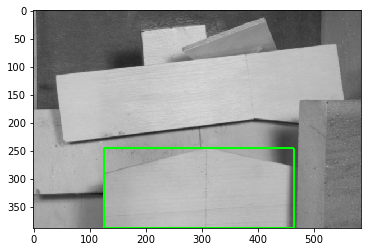

Optical flow computed
10.923767035684236
[126, 245, 464, 387]
[125, 245, 463, 387]


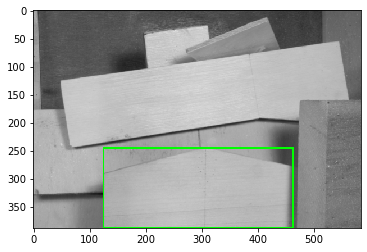

Optical flow computed
8.006281727520413
[125, 245, 463, 387]
[123, 244, 461, 386]


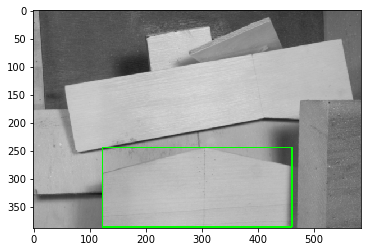

Optical flow computed
10.057297069740102
[123, 244, 461, 386]
[122, 244, 460, 386]


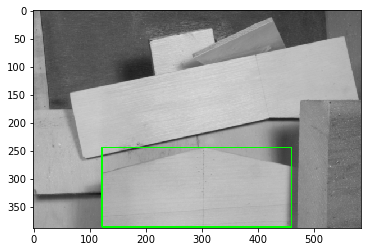

saving images
Save complete. Output saved in ./outputs/Wooden
Video path ./outputs/Wooden/output/video.mp4


In [12]:
    dataset_complete = './eval-data-gray-complete'
    directory = '/Wooden'
    bbox = [208, 284, 338, 461]
    bounding_box_tracking(dataset_complete + directory)

0
1
2
3
4
5
6
7
Draw bounding box
Optical flow computed
0.8184656705512934
[133, 287, 233, 387]
[131, 287, 231, 387]


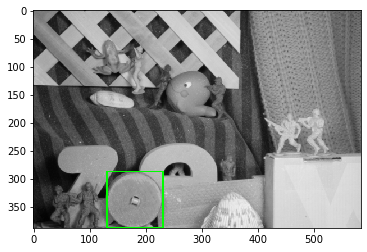

Optical flow computed
0.7976839057900222
[131, 287, 231, 387]
[130, 287, 230, 387]


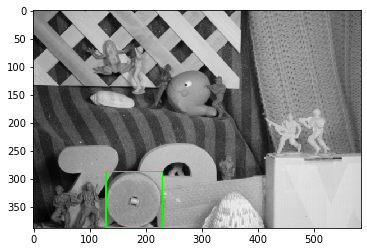

Optical flow computed
0.9922584465831683
[130, 287, 230, 387]
[129, 287, 229, 387]


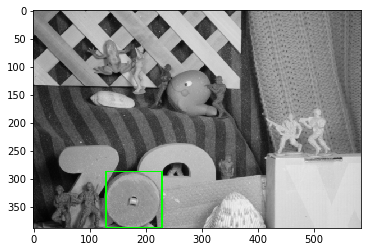

Optical flow computed
1.1979513086552462
[129, 287, 229, 387]
[128, 287, 228, 387]


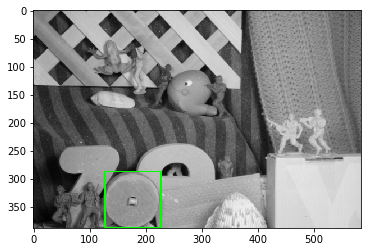

Optical flow computed
0.8840247808526494
[128, 287, 228, 387]
[127, 287, 227, 387]


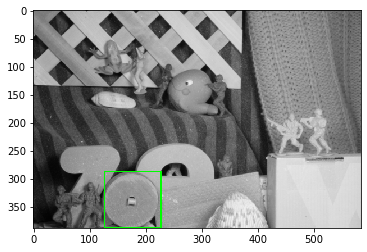

Optical flow computed
0.8523037766728652
[127, 287, 227, 387]
[125, 287, 225, 387]


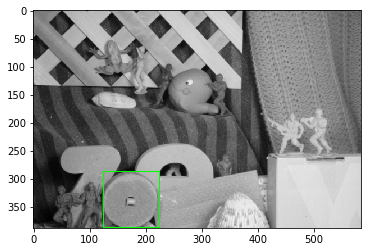

Optical flow computed
0.9090683717332151
[125, 287, 225, 387]
[124, 287, 224, 387]


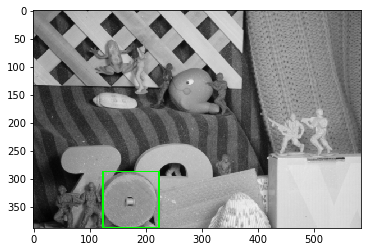

saving images
Save complete. Output saved in ./outputs/Army
Video path ./outputs/Army/output/video.mp4


In [13]:
    dataset_complete = './eval-data-gray-complete'
    directory = '/Army'
    bbox = [208, 284, 338, 461]
    bounding_box_tracking(dataset_complete + directory)

Optical flow computed
1.8176778334267094


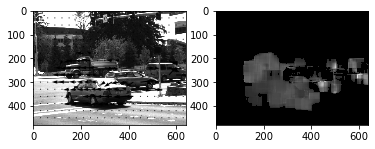

In [14]:
    dataset = './eval-data-gray'
    
    directory = '/Dumptruck'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    plt.subplot(121)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)
    plt.subplot(122)
    segmentation(image_1, flow_matrix)
    

Optical flow computed
0.8440589903756118


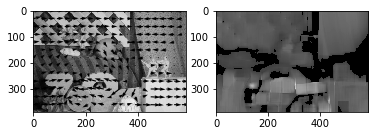

In [15]:
    directory = '/Army'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    plt.subplot(121)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)
    plt.subplot(122)
    segmentation(image_1, flow_matrix)